# Using EcoFOCIpy to process raw field data

## Mooring / Timeseries Data

Basic workflow for each instrument grouping is *(initial archive level)*:
- Parse data from raw files into pandas dataframe
- output initial files (pandas->csv) **ERDDAP NRT** when no meta data is added

Convert to xarray dataframe for all following work *(working or final data level):
- TODO: Add metadata from instrument yaml files and/or header info
- ingest metadata from deployment/recovery records or cast logs
- process data beyond simple file translate
- apply any calibrations or corrections
    + field corrections
    + offsets
    + instrument compensations
    + some QC were available... this would be old-school simple bounds mostly
- adjust time bounds and sample frequency (xarray dataframe)
- save as CF netcdf via xarray: so many of the steps above are optional
    + **ERDDAP NRT** if no corrections, offsets or time bounds are applied but some meta data is
    + **Working and awaiting QC** has no ERDDAP representation and is a holding spot
    + **ERDDAP Final** fully calibrated, qc'd and populated with meta information

Plot for preview and QC
- preview images (indiv and/or collectively)
- manual qc process
- automated qc process ML/AI

Further refinenments for ERDDAP hosting:


## Example below is for EcoFluorometer with three channels (Eco triplets of various design) but the workflow is similar for all instruments.

Future processing of this instrument can be a simplified (no markdown) process which can be archived so that the procedure can be traced or updated

In [1]:
import yaml

import EcoFOCIpy.io.wetlabs_parser as wetlabs_parser #<- instrument specific
import EcoFOCIpy.io.ncCFsave as ncCFsave
import EcoFOCIpy.metaconfig.load_config as load_config

The sample_data_dir should be included in the github package but may not be included in the pip install of the package

## Simple Processing - first step

In [2]:
sample_data_dir = '../'

In [3]:
###############################################################
# edit to point to {instrument sepcific} raw datafile 
datafile = sample_data_dir+'staticdata/example_data/ecobbfl2w_sample.txt'
instrument = 'ECO-Fluorometer BBFL2W 1419'
mooring_meta_file = sample_data_dir+'staticdata/mooring_example.yaml'
inst_meta_file = sample_data_dir+'staticdata/instr_metaconfig/ecofluor.yaml'
inst_shortname = 'eco'
###############################################################

#init and load data
eco = wetlabs_parser.wetlabs()
(eco_data,eco_header) = eco.parse(filename=datafile,
                                                    return_header=True,
                                                    datetime_index=True) 

In [4]:
eco_header

['timecheck:\n',
 'realtime: 195610\n',
 'instime: 194106\n',
 'Ser BBFL2W-1419\n',
 'Ver Triplet5.33\n',
 'Ave 18\n',
 'Pkt 7\n',
 'M1d 50\n',
 'M2d 53\n',
 'M3d 44\n',
 'M1s 4.850E-02\n',
 'M2s 1.820E-02\n',
 'M3s 9.030E-02\n',
 'Seq 0\n',
 'Rat 19200\n',
 'Set 1\n',
 'Rec 1\n',
 'Man 0\n',
 'Int 00:30:00\n',
 'Dat 12/13/18\n',
 'Clk 18:59:43\n',
 'Mst 00:37:39\n',
 'Mem 3357\n',
 '$get\n']

In [5]:
eco_data

,700,695,460,TempCount
date_time,,,,
2017-06-30 21:14:46,4130,550,4130,532
2017-06-30 21:14:47,4130,541,4130,532
2017-06-30 21:14:48,4130,544,4130,532
2017-06-30 21:15:11,51,63,55,532
2017-06-30 21:15:12,51,65,59,532
...,...,...,...,...
2017-08-07 10:00:10,4130,580,4130,558
2017-08-07 10:00:12,4130,580,4130,558
2017-08-07 10:00:13,4130,580,4130,558


### Engr2Sci Calibration (unique to wetlabs instruments)

Must apply the known cal factors from the lab to the raw data to get science data.  These are linear transformations of the form `y=mx+b`, so a slope (m) and offset (b) should be provided.  Each channel has its own cal factor.  Currently there is no routine to read these from a database or file, so you need to input them into the object method.  

Change the name of each channel below to be that of the column label (wavelenght), and change the 'outname' to be the netcdf CF compliant variable name (in the instrument yaml files)

In [6]:
cal_coef = {695:{'scaleFactor':0.0182,'darkCounts':53.0,'outname':'chlor_fluorescence'},
            700:{'scaleFactor':0.0485,'darkCounts':50.0,'outname':'turbidity'},
            460:{'scaleFactor':0.0903,'darkCounts':44.0,'outname':'cdom'}            
            }

eco.engr2sci(cal_coef=cal_coef)

,700,695,460,TempCount,chlor_fluorescence,turbidity,cdom
date_time,,,,,,,
2017-06-30 21:14:46,4130,550,4130,532,9.0454,197.8800,368.9658
2017-06-30 21:14:47,4130,541,4130,532,8.8816,197.8800,368.9658
2017-06-30 21:14:48,4130,544,4130,532,8.9362,197.8800,368.9658
2017-06-30 21:15:11,51,63,55,532,0.1820,0.0485,0.9933
2017-06-30 21:15:12,51,65,59,532,0.2184,0.0485,1.3545
...,...,...,...,...,...,...,...
2017-08-07 10:00:10,4130,580,4130,558,9.5914,197.8800,368.9658
2017-08-07 10:00:12,4130,580,4130,558,9.5914,197.8800,368.9658
2017-08-07 10:00:13,4130,580,4130,558,9.5914,197.8800,368.9658


## Time properties

Its unusual that our clocks drift to the point of concern for our instruments (if an instrument is off by 3 minutes but only sampling hourly... regridding that data will result in minimal changes).  However, there are a few time oriented modifications that may need to be made.

The can be classified into two categories:
+ interpolate: these change the parameter values in accordance with the time edits
    - linear interpolation is most common
    - averaging of data and rebinning/resampling is also common (this needs to have the "time lable" thought out...)
    - decimating is less common but does not impact the max/min values
+ shift: these do not alter the measurements, just the timestamps they are associated with
    - the round function will work well to correct small time errors/drifts **common**
    - dropping extra precision on time (if you want hourly measurements, just remove all minute/second info... could cause large errors if rounding would have been more appropriate)

It is very easy to use pandas interplation and resample methods on the dataframe as is.  A few steps are suggested below:
- parse out on-deck (predeployment and recovery) data.  This can be done via pandas or xarray but requires the mooring metadata to have been read in.  See future steps below.
- even if the sample frequency is set to the desired measurement frequency, it would be good to perform a quick regridding as an assurance task
- FOCI data is usualy 1min, 10min, 1hr - and the 1min data is a fairly new (sbe56) data stream
    + subsampling high frequency data to lower frequency is easy via df.resample().mean() but it will label the new datapoint per default instructions.  The default is to label it with the left boundary of the bin.
    + you may want to take the median instead of the mean for noisy data (fluorometer) , occasionally decimating may be more appropriate if you want to downsize the dataset size but not smear features
    + shifting times can be a bit more involved.  There are two primary ways to do it, interpolate or shift (round)
        - to interpolate, you will need to upsample your data to a higher frequency which will generate missing values, then interpolate (with a maximum gap size), then decimate.  This always has the artifact of smoothing data and decreasing the min/max values. **common on microcats and other 10min datasets**
        - shifting usually just involves droping extra time "digits", if you want hourly, you could just drop the trailing minutes assuming you are just off the hour (8:05 -> 8:00) or you can round to the nearest time unit but niether of these changes the data value, just the time associated with it. **common on seacats and other hourly datasets**
        - you may also be able to *shift* using the pandas datetime round function and specifing the desired frequency.
    + I suggest if no change is needed... df.index.round(freq=*'your native sample freq'*)
    

### Special note for Wetlabs times

Historically these instruments have drifted significantly.  (usually to be slow) We keep track of the shift in seconds. and we do burst measurements with them.  How you want to tackle this is gonna be dependent on each instrument.  Goal is to stick to simple timeseries analysis via pandas though (as opposed to determining when the groups of each burst are sampled)

In [7]:
eco_data = eco.time_correction(offset=854) #positive to catch up with GPS time - linear correction may need to be applied... this is an offset shift at the moment 
eco_data

,700,695,460,TempCount,chlor_fluorescence,turbidity,cdom
date_time,,,,,,,
2017-06-30 21:29:00,4130,550,4130,532,9.0454,197.8800,368.9658
2017-06-30 21:29:01,4130,541,4130,532,8.8816,197.8800,368.9658
2017-06-30 21:29:02,4130,544,4130,532,8.9362,197.8800,368.9658
2017-06-30 21:29:25,51,63,55,532,0.1820,0.0485,0.9933
2017-06-30 21:29:26,51,65,59,532,0.2184,0.0485,1.3545
...,...,...,...,...,...,...,...
2017-08-07 10:14:24,4130,580,4130,558,9.5914,197.8800,368.9658
2017-08-07 10:14:26,4130,580,4130,558,9.5914,197.8800,368.9658
2017-08-07 10:14:27,4130,580,4130,558,9.5914,197.8800,368.9658


In [8]:
#the smaller you resample, the closer to the "minute" you will be
# tehn you can determin if you round or interpolate

eco_data = eco_data.resample('2T').median().interpolate()
eco_data=eco_data[eco_data.index.minute==0]

eco_data

,700,695,460,TempCount,chlor_fluorescence,turbidity,cdom
date_time,,,,,,,
2017-06-30 22:00:00,2092.288824,304.658338,2095.786612,532.011378,4.580182,99.051008,185.276331
2017-06-30 23:00:00,2094.705369,304.955221,2098.199008,532.032710,4.585585,99.168210,185.494170
2017-07-01 00:00:00,2097.121914,305.252104,2100.611405,532.054043,4.590988,99.285413,185.712010
2017-07-01 01:00:00,2099.538458,305.548987,2103.023802,532.075376,4.596392,99.402615,185.929849
2017-07-01 02:00:00,2101.955003,305.845870,2105.436199,532.096709,4.601795,99.519818,186.147689
...,...,...,...,...,...,...,...
2017-08-07 07:00:00,4130.000000,587.533333,4130.000000,557.000000,9.728507,197.880000,368.965800
2017-08-07 08:00:00,4130.000000,599.500000,4130.000000,557.766667,9.946300,197.880000,368.965800
2017-08-07 09:00:00,4130.000000,593.800000,4130.000000,558.000000,9.842560,197.880000,368.965800


<AxesSubplot:xlabel='date_time'>

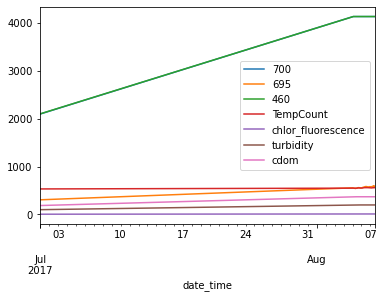

In [9]:
eco_data.plot()

## Add Deployment meta information

Two methods are available (if comming from python2 world - ordereddict was important... in py38 a dictionary is inherently ordered)

In [10]:
#just a dictionary of dictionaries - simple
with open(mooring_meta_file) as file:
    mooring_config = yaml.full_load(file)

In [11]:
#Generates an ordereddict but prints better for summary
#likely to be depricated as an ordered dict may not be useful and drops a dependency if its EOL
mooring_config_v2 = load_config.load_config(mooring_meta_file)

In [12]:
mooring_config['Instrumentation'][instrument]

{'InstType': 'Eco-Fluorometer BBFL2W',
 'SerialNo': '1419',
 'DesignedDepth': 0.0,
 'ActualDepth': 0.0,
 'PreDeploymentNotes': 'Not actually deployed - test instrument',
 'PostDeploymentNotes': '',
 'Deployed': 'n',
 'Recovered': 'n'}

## Add Instrument meta information

Time, depth, lat, lon should be added regardless (always our coordinates) but for a mooring site its going to be a (1,1,1,t) dataset
The variables of interest should be read from the data file and matched to a key for naming.  That key is in the inst_config file seen below and should represent common conversion names in the raw data

In [13]:
with open(inst_meta_file) as file:
    inst_config = yaml.full_load(file)
inst_config

{'time': {'epic_key': 'TIM_601',
  'name': 'time',
  'generic_name': 'time',
  'standard_name': 'time',
  'long_name': 'date and time since reference time',
  'time_origin': '1900-01-01 00:00:00',
  'units': 'days since 1900-01-01T00:00:00Z'},
 'depth': {'epic_key': 'D_3',
  'generic_name': 'depth',
  'units': 'meter',
  'long_name': 'depth below surface (meters)',
  'standard_name': 'depth'},
 'latitude': {'epic_key': 'LON_501',
  'name': 'latitude',
  'generic_name': 'latitude',
  'units': 'degrees_north',
  'long_name': 'latitude',
  'standard_name': 'latitude'},
 'longitude': {'epic_key': 'LAT_500',
  'name': 'longitude',
  'generic_name': 'longitude',
  'units': 'degrees_east',
  'long_name': 'longitude',
  'standard_name': 'longitude'},
 'timeseries_id': {'cf_role': 'timeseries_id',
  'long_name': 'timeseries id',
  'standard_name': ''},
 'fluor_counts': {'epic_key': 'fluor_3031',
  'generic_name': 'fluor_counts',
  'long_name': 'Digital Counts from fluorometer',
  'standard_name

In [14]:
# Add meta data and prelim processing based on meta data
# Convert to xarray and add meta information - save as CF netcdf file
# pass -> data, instmeta, depmeta
eco_data_nc = ncCFsave.EcoFOCI_CFnc(df=eco_data, 
                                instrument_yaml=inst_config, 
                                operation_yaml=mooring_config,
                                operation_type = 'mooring', 
                                instrument_id=instrument, 
                                inst_shortname=inst_shortname)
eco_data_nc

At this point, you could save your file with the `.xarray2netcdf_save()` method and have a functioning dataset.... but it would be very simple with no additional qc, meta-data, or tuned parameters for optimizing software like ferret or erddap.

In [15]:
# expand the dimensions and coordinate variables
# renames them appropriatley and prepares them for meta-filled values
eco_data_nc.expand_dimensions()

In [16]:
eco_data_nc.variable_meta_data(variable_keys=list(eco_data.columns.values),drop_missing=True)
eco_data_nc.temporal_geospatioal_meta_data()
#adding dimension meta needs to come after updating the dimension values... BUG?
eco_data_nc.dimension_meta_data(variable_keys=['depth','latitude','longitude'])

The following steps can happen in just about any order and are all meta-data driven.  Therefore, they are not required to have a functioning dataset, but they are required to have a well described dataset

In [17]:
#add global attributes
eco_data_nc.deployment_meta_add()
eco_data_nc.get_xdf()

#add instituitonal global attributes
eco_data_nc.institution_meta_add()

#add creation date/time - provenance data
eco_data_nc.provinance_meta_add()

#provide intial qc status field
eco_data_nc.qc_status(qc_status='unknown')


## Save CF Netcdf files

Currently stick to netcdf3 classic... but migrating to netcdf4 (default) may be no problems for most modern purposes.  Its easy enough to pass the `format` kwargs through to the netcdf api of xarray.

In [18]:
# combine trim (not mandatory) and filename together (saves to test.nc without name)

depth = str(int(mooring_config['Instrumentation'][instrument]['ActualDepth'])).zfill(4)
# mooring_yaml['Instrumentation'][self.instrument_id]['DesignedDepth'])).zfill(4) #<-- alternative
filename = "".join(mooring_config['MooringID'].split('-')).lower()+'_'+inst_shortname+'_'+depth+'m.nc'
eco_data_nc.xarray2netcdf_save(xdf = eco_data_nc.autotrim_time(),
                           filename=filename,format="NETCDF3_CLASSIC")

# don't trim the data and pass your own filename
# eco_data_nc.xarray2netcdf_save(xdf = eco_data_nc.get_xdf(),
#                            filename=filename,format="NETCDF4_CLASSIC")

In [19]:
eco_data_nc.get_xdf()

<xarray.Dataset>
Dimensions:             (depth: 1, latitude: 1, longitude: 1, time: 902)
Coordinates:
  * time                (time) datetime64[ns] 2017-06-30T22:00:00 ... 2017-08...
  * latitude            (latitude) float64 56.87
  * longitude           (longitude) float64 -164.0
  * depth               (depth) float64 0.0
Data variables:
    chlor_fluorescence  (time, depth, latitude, longitude) float64 4.58 ... 9...
    turbidity           (time, depth, latitude, longitude) float64 99.05 ... ...
    cdom                (time, depth, latitude, longitude) float64 185.3 ... ...
Attributes: (12/13)
    Latitude-Deg_MM.dd_W:                   56 52.1729 N
    Longitude-Deg_MM.dd_N:                  164 02.8716 W
    MooringID:                              16BSM-2A
    platform_deployment_date:               2016-05-05T05:51:00Z
    platform_deployment_cruise_name:        DY1606
    platform_recovery_date:                 2016-09-29T03:45:00Z
    ...                                     ...
    platform_deployment_recovery_comments:  Depth not listed - other two moor...
    WaterDepth:                             71.0
    date_created:                           2021-04-23T13:55:20Z
    date_modified:                          
    QC_indicator:                           unknown
    history:                                Trimmed to deployment.

## Next Steps

QC of data (plot parameters with other instruments)
- be sure to updated the qc_status and the history